# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf, Cdf
from utils import decorate, savefig

## Cumulative Distribution Functions

In [3]:
from scipy.stats import binom

def update_binomial(pmf, data):
    """Update the PMF using the binomial distribution.
    
    pmf: Pmf representing the prior
    data: tuple of integers k and n
    """
    k, n = data
    xs = pmf.qs
    likelihood = binom.pmf(k, n, xs)
    pmf *= likelihood
    pmf.normalize()

In [4]:
hypos = np.linspace(0, 1, 101)
pmf = Pmf(1, hypos)
data = 140, 250
update_binomial(pmf, data)

In [5]:
cumulative = pmf.cumsum()

In [6]:
def decorate_euro(title):
    decorate(xlabel='Proportion of heads (x)',
             ylabel='Probability',
             title=title)

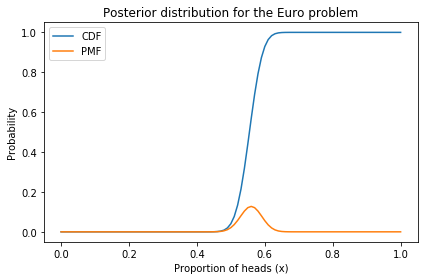

In [7]:
cumulative.plot(label='CDF')
pmf.plot(label='PMF')
decorate_euro(title='Posterior distribution for the Euro problem')
savefig('fig06-01')

In [8]:
pmf[0.61]

0.034875155909278366

In [9]:
cumulative[0.61]

0.9638303193984253

In [10]:
from scipy.interpolate import interp1d

ps = cumulative.values
qs = cumulative.index

interp = interp1d(ps, qs)
interp(0.96)

array(0.60890171)

In [11]:
cdf = pmf.make_cdf()
cdf[0.61]

0.9638303193984253

In [12]:
try:
    cdf[0.615]
except KeyError as e:
    print('KeyError')

KeyError


In [13]:
cdf(0.615)

array(0.96383032)

In [14]:
cdf.quantile(0.9638303)

array(0.61)

In [15]:
cdf.credible_interval(0.9)

array([0.51, 0.61])

## Maximum

In [16]:
def make_die(sides):
    """Pmf that represents a die with the given number of sides.
    
    sides: int
    
    returns: Pmf
    """
    outcomes = np.arange(1, sides+1)
    die = Pmf(1/sides, outcomes)
    return die

In [17]:
def add_dist_seq(seq):
    """Distribution of sum of values from PMFs.
    
    seq: sequence of Pmf objects
    
    returns: Pmf
    """
    total = seq[0]
    for other in seq[1:]:
        total = total.add_dist(other)
    return total

In [18]:
die = make_die(6)
dice = [die] * 3

In [19]:
pmf_3d6 = add_dist_seq(dice)

In [20]:
def decorate_dice(title=''):
    decorate(xlabel='Outcome',
             ylabel='PMF',
             title=title)
    

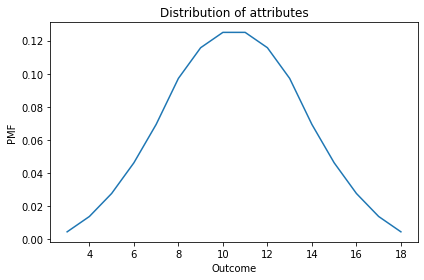

In [21]:
pmf_3d6.plot()
decorate_dice('Distribution of attributes')

In [22]:
n = 10000
a = np.random.randint(1, 7, size=(n, 4))
a.sort(axis=1)
t = a[:, 1:].sum(axis=1)

In [23]:
pmf_4d6 = Pmf.from_seq(t)

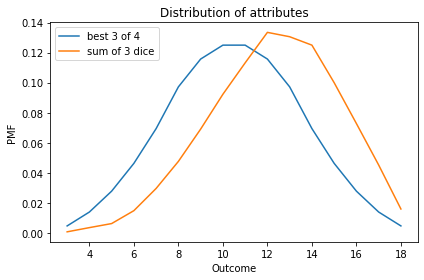

In [34]:
pmf_3d6.plot(label='best 3 of 4')
pmf_4d6.plot(label='sum of 3 dice')

decorate_dice('Distribution of attributes')

In [35]:
from empiricaldist import Cdf

cdf_4d6 = pmf_4d6.make_cdf()
cdf_max6 = Cdf(cdf_4d6**6)

In [36]:
pmf_max6 = cdf_max6.make_pmf()

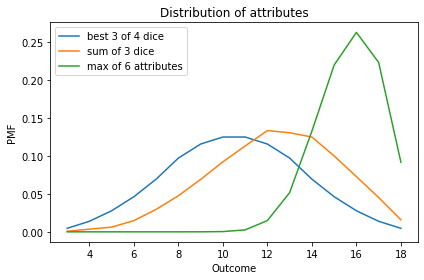

In [37]:
pmf_3d6.plot(label='best 3 of 4 dice')
pmf_4d6.plot(label='sum of 3 dice')
pmf_max6.plot(label='max of 6 attributes')

decorate_dice('Distribution of attributes')

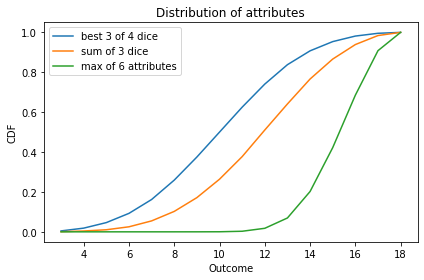

In [48]:
cdf_3d6 = pmf_3d6.make_cdf()
cdf_3d6.plot(label='best 3 of 4 dice')

cdf_4d6 = pmf_4d6.make_cdf()
cdf_4d6.plot(label='sum of 3 dice')

cdf_max6.plot(label='max of 6 attributes')

decorate_dice('Distribution of attributes')
plt.ylabel('CDF');

Now let's compute the distribution for the minimum of your six attributes.

Remember that `Cdf(x)` is the probability that a value from the distribution is less than or equal to `x`.

So we can compute the probability that a value is greater than `x`, like this:

In [55]:
prob_gt = 1 - cdf_4d6
prob_gt

3     0.9993
4     0.9958
5     0.9896
6     0.9748
7     0.9452
8     0.8976
9     0.8285
10    0.7362
11    0.6230
12    0.4895
13    0.3589
14    0.2339
15    0.1339
16    0.0611
17    0.0159
18    0.0000
dtype: float64

Now here's the probability that all six values are greater than `x`:

In [56]:
prob_gt6 = prob_gt**6
prob_gt6

3     9.958073e-01
4     9.750631e-01
5     9.392001e-01
6     8.580115e-01
7     7.130866e-01
8     5.229944e-01
9     3.234112e-01
10    1.592117e-01
11    5.846935e-02
12    1.375676e-02
13    2.137178e-03
14    1.637500e-04
15    5.763462e-06
16    5.202921e-08
17    1.615782e-11
18    0.000000e+00
dtype: float64

And finally the probability that all six values are less than or equal to `x`.

In [57]:
prob_le6 = 1-prob_gt6
prob_le6

3     0.004193
4     0.024937
5     0.060800
6     0.141988
7     0.286913
8     0.477006
9     0.676589
10    0.840788
11    0.941531
12    0.986243
13    0.997863
14    0.999836
15    0.999994
16    1.000000
17    1.000000
18    1.000000
dtype: float64

The result is a Pandas Series that represents the CDF of the minimum of six attributes.  We can put those values in a `Cdf` object like this:

In [ ]:
cdf_min6 = Cdf(prob_le6)

Here's what it looks like.

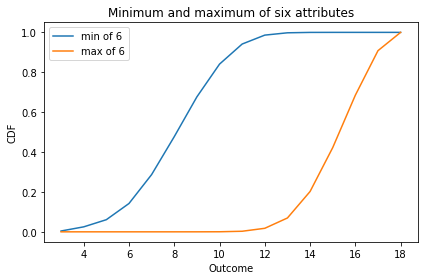

In [66]:
cdf_min6.plot(label='min of 6')
cdf_max6.plot(label='max of 6')
decorate_dice('Minimum and maximum of six attributes')
plt.ylabel('CDF');

When you generate a D&D character, instead of rolling dice, you can use the "standard array" of attributes, which is 15, 14, 13, 12, 10, and 8.

You can create a `Cdf` that represents the distribution of attributes in the standard array like this:

In [71]:
standard = [15,14,13,12,10,8]
cdf_standard = Cdf.from_seq(standard)

And we can compare it to the distribution of attributes you get by rolling four dice at adding up the best three.

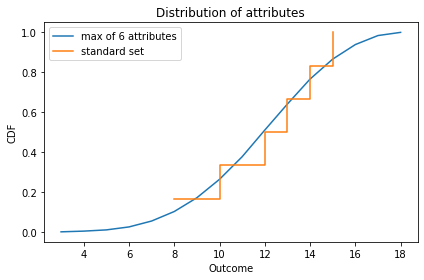

In [72]:
cdf_4d6.plot(label='max of 6 attributes')
cdf_standard.step(label='standard set')

decorate_dice('Distribution of attributes')
plt.ylabel('CDF');

I plotted `cdf_standard` as a step function to show more clearly that it contains only a few values.

**Exercise:** Now, do you think you are better of using the standard array or (literally) rolling the dice?

* Which distribution has higher mean?  Use the `mean` method.

* Which distribution has higher standard deviation?  Use the `std` method.

* The lowest value in the standard array is 8.  For each attribute, what is the probability of getting a value less than 8?

* If you roll the dice six times, what's the probability that at least one of your attributes is less than 8?

* The highest value in the standard array is 15.  For each attribute, what is the probability of getting a value greater than 15?

* If you roll the dice six times, what's the probability that at least one of your attributes is greater than 15?

In [73]:
cdf_4d6.mean(), cdf_standard.mean()

(12.2832, 12.0)

In [74]:
cdf_4d6.std(), cdf_standard.std()

(2.835630046391807, 2.3804761428476167)

In [75]:
cdf_4d6.lt_dist(8)

0.0548

In [76]:
cdf_4d6.gt_dist(15)

0.13390000000000002

In [77]:
cdf_min6.lt_dist(8), 1 - (1-cdf_4d6.lt_dist(8))**6

(0.28691339621956324, 0.28691339621956324)

In [78]:
cdf_max6.gt_dist(15), 1 - (1-cdf_4d6.gt_dist(15))**6

(0.5779069205585887, 0.5779069205585887)

## Mixture

In [ ]:
d4 = make_die(4)

In [ ]:
total = d4.add(d6, fill_value=0)
mix = Pmf(total)
mix.normalize()
mix.bar(alpha=0.7)
decorate_dice()

In [ ]:
total = d4.add(2*d6, fill_value=0)
mix = Pmf(total)
mix.normalize()
mix.bar(alpha=0.7)
decorate_dice()

In [ ]:
hypos = [4,6,8]
counts = [1,2,3]
pmf_dice = Pmf(counts, hypos)
pmf_dice.normalize()
pmf_dice

In [ ]:
dice = [make_die(sides) for sides in hypos]

In [ ]:
product = pmf_dice * dice
product[4]

In [ ]:
def add_pmf_seq(seq):
    """Add up a sequence of PMFs.
    
    seq: sequence of Pmf
    
    returns: Pmf
    """
    total = seq[0]
    for other in seq[1:]:
        total = total.add(other, fill_value=0)
    return Pmf(total)

In [ ]:
add_pmf_seq(product.values)

In [ ]:
def make_mixture(pmf, pmf_seq):
    """Make a mixture of distributions.
    
    pmf: mapping from each hypothesis to its probability
    pmf_seq: sequence of Pmfs, each representing 
             a conditional distribution
    """
    product = pmf * pmf_seq
    return add_pmf_seq(product.values)

In [ ]:
mix = make_mixture(pmf_dice, dice)
mix.bar(label='mixture', alpha=0.6)
decorate_dice()

In [ ]:
mix.sum()